In [1]:
import pandas as pd
import shap

df = pd.read_csv(r'D:\AI-Finance\archive\credit_risk_dataset.csv')

df.head()

d:\AI-Finance\AI-Finance_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [2]:
X = df[['person_income', 'loan_amnt', 'loan_percent_income', 
        'person_home_ownership', 'cb_person_default_on_file']]
y = df['loan_status']

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [4]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBClassifier

numeric_features = ['person_income', 'loan_amnt', 'loan_percent_income']
categorical_features = ['person_home_ownership', 'cb_person_default_on_file']

In [5]:
prepocessor = ColumnTransformer(
    transformers= [
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

clf_pipeline = Pipeline(
    steps= [
        ('preprocessing', prepocessor),
        ('classifying', XGBClassifier(n_estimators=100, learning_rate=0.1))
    ]
)

clf_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('classifying', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transfor

In [6]:
from sklearn.metrics import accuracy_score

model= clf_pipeline.fit(X_train, y_train)
y_pred= model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8704925579254258

In [7]:
joblib.dump(model, 'credit_risk_pipeline.joblib')
print("Model Pipeline saved successfully as credit_risk_pipeline.joblib")

Model Pipeline saved successfully as credit_risk_pipeline.joblib


In [ ]:
import shap
import matplotlib.pyplot as plt

# 1. Get the transformed feature names (since OneHotEncoder creates new columns)
# This extracts the feature names from the 'preprocessing' step of your pipeline
ohe_features = (clf_pipeline.named_steps['preprocessing']
                .named_transformers_['cat']
                .get_feature_names_out(categorical_features))
all_features = numeric_features + list(ohe_features)

In [9]:
# 2. Transform the test data using the pipeline's preprocessor
X_test_transformed = clf_pipeline.named_steps['preprocessing'].transform(X_test)

# 3. Create the Explainer using the model inside the pipeline
# We use the 'classifying' step (the XGBoost model)
model_inside = clf_pipeline.named_steps['classifying']
explainer = shap.TreeExplainer(model_inside)
shap_values = explainer.shap_values(X_test_transformed)

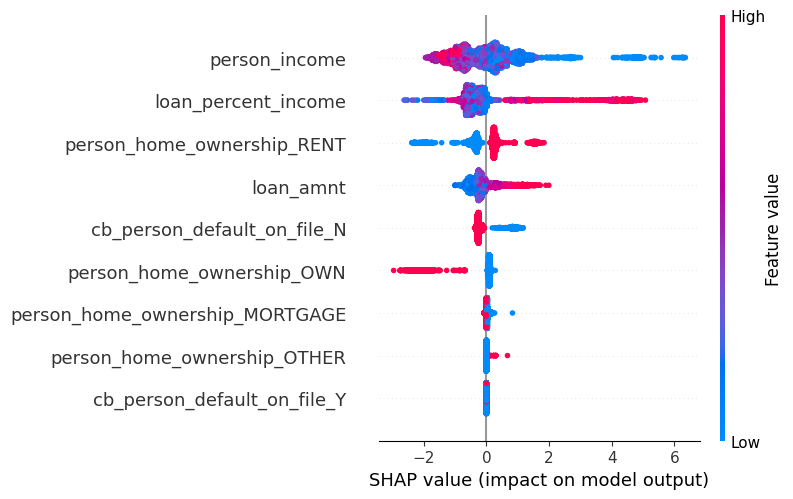

In [10]:
# --- Plot 1: Summary Plot ---
plt.figure()
shap.summary_plot(shap_values, X_test_transformed, feature_names=all_features)

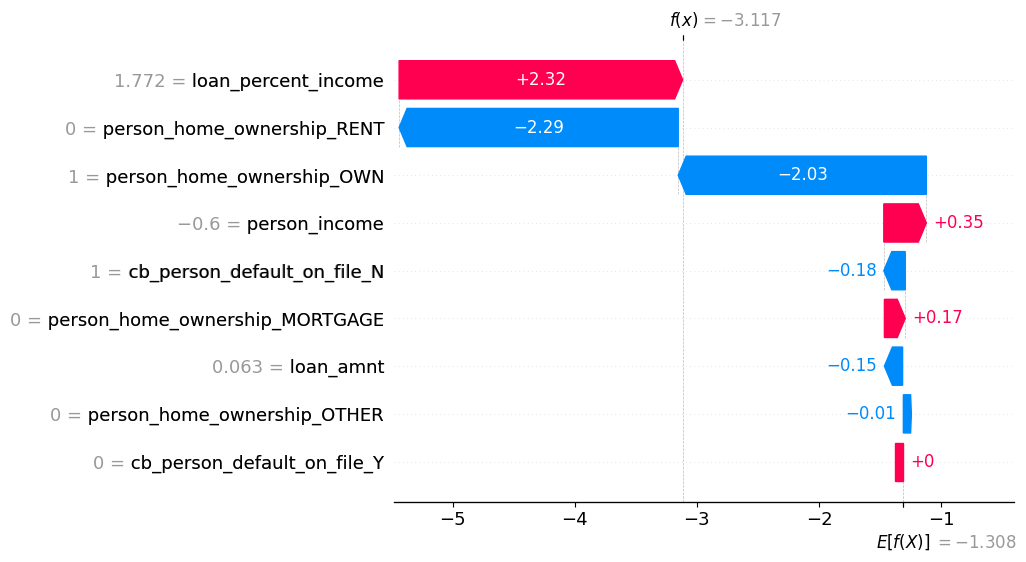

In [11]:
# --- Plot 2: Waterfall Plot (for the first prediction) ---
# For Waterfall, we need a SHAP Explanation object
explanation = shap.Explanation(
    values=shap_values[0], 
    base_values=explainer.expected_value, 
    data=X_test_transformed[0], 
    feature_names=all_features
)
plt.figure()
shap.plots.waterfall(explanation)